## Import Libraries

In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn import Softmax
from torcheval.metrics import MulticlassAccuracy,MulticlassConfusionMatrix
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import RandomNodeSplit
import matplotlib.pyplot as plt
import os


## Load the Dataset

In [2]:
num_val = 200
num_test = 500

cora = Planetoid(
    root=".",
    name="Cora",
    transform=RandomNodeSplit(
        num_val=num_val,
        num_test=num_test,
    )
)

data = cora[0]

print('Number of nodes:', data.x.shape[0])
print('Number of edges:', data.edge_index.shape[1])
print('Number of features:', cora.num_features)
print('Number of classes:', cora.num_classes)

Processing...


Number of nodes: 2708
Number of edges: 10556
Number of features: 1433
Number of classes: 7


Done!


##  Initialize the Graph Neural Network[3 layers]

In [3]:
class GCN(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)

        self.conv1 = GCNConv(cora.num_features, 500)
        self.conv2 = GCNConv(500, 100)
        self.conv3 = GCNConv(100, cora.num_classes)

    def forward(self, x, edge_index,return_emb=False):
        h = self.conv1(x, edge_index)
        h = torch.tanh(h)

        h = self.conv2(h, edge_index)
        h = torch.tanh(h)
        if return_emb:
            return h
        h = self.conv3(h, edge_index)
        return h   # RAW LOGITS



## Initialize ANN

In [4]:
class ANN(nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(1234)
    self.layer1=nn.Linear(cora.num_features,500)
    self.layer2=nn.Linear(500,100)
    self.layer3=nn.Linear(100,cora.num_classes)
    
  def forward(self,x,return_emb=False):
    h=self.layer1(x)
    h=h.tanh()
    h=self.layer2(h)
    h=h.tanh()
    if return_emb:
            return h
    h=self.layer3(h)
    
    return h
    

##  Initialize the Graph Neural Network[3 layers]

In [5]:
#gnn with 2 layers
class GCN1(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(cora.num_features, 100)
        self.conv2 = GCNConv(100, cora.num_classes)
        self.classifier = Softmax(dim=1)
    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)

        return h


## Define the Training Function for GNN

In [6]:
def train(model, optimizer, criterion, data):
    # Train the model
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    train_loss = criterion(out[data.train_mask], data.y[data.train_mask])
    train_loss.backward()
    optimizer.step()
    val_loss = criterion(out[data.val_mask], data.y[data.val_mask])

    return train_loss, val_loss

## Define the Training Function for ANN

In [7]:
def train1(model, optimizer, criterion, data):
    # Train the model
    model.train()
    optimizer.zero_grad()
    out = model(data.x)
    train_loss = criterion(out[data.train_mask], data.y[data.train_mask])
    train_loss.backward()
    optimizer.step()
    val_loss = criterion(out[data.val_mask], data.y[data.val_mask])

    return train_loss, val_loss

## Define the Evaluation Function for GNN

In [8]:
def eval(model, data, data_mask):
    model.eval()

    with torch.no_grad():
        out = model(data.x, data.edge_index)
    
    predicted_labels = out.argmax(dim=1)[data_mask]

    # Evaluate model accuracy
    y = data.y[data_mask]
    acc_metric = MulticlassAccuracy()
    acc_metric.update(predicted_labels, y)

    # Evaluate confusion matrix
    cf_metric = MulticlassConfusionMatrix(cora.num_classes)
    cf_metric.update(predicted_labels, y)

    return acc_metric.compute(), cf_metric.compute()

## Define the Evaluation Function for ANN

In [9]:
def eval1(model, data, data_mask):
    model.eval()

    with torch.no_grad():
        out = model(data.x)
    
    predicted_labels = out.argmax(dim=1)[data_mask]

    # Evaluate model accuracy
    y = data.y[data_mask]
    acc_metric = MulticlassAccuracy()
    acc_metric.update(predicted_labels, y)

    # Evaluate confusion matrix
    cf_metric = MulticlassConfusionMatrix(cora.num_classes)
    cf_metric.update(predicted_labels, y)

    return acc_metric.compute(), cf_metric.compute()

## Extract Embedings

In [10]:
def extract_embeddings(model, data):
    model.eval()
    with torch.no_grad():
        embeddings = model(
            data.x,
            data.edge_index,
            return_emb=True
        )
    return embeddings


In [11]:
def extract_embeddings_ann(model, data):
    model.eval()
    with torch.no_grad():
        embeddings = model(
            data.x,
            return_emb=True
        )
    return embeddings


## Modularize the Training Process

In [17]:
def train_cora(test_pc, epochs):

    dataset = Planetoid(".", "Cora")
    data = dataset[0]   # <-- THIS is the Data object

    num_test = int(data.num_nodes * test_pc)
    num_val  = int(data.num_nodes * 0.1)

    data = RandomNodeSplit(
        num_val=num_val,
        num_test=num_test
    )(data)

    model = GCN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()

    train_loss_arr, val_loss_arr, test_acc_arr = [], [], []

    min_val_loss = float('inf')
    patience = 0
    epsilon = 1e-4

    for epoch in range(epochs):
        train_loss, _ = train(model, optimizer, criterion, data)
        train_loss_arr.append(train_loss.item())

        model.eval()
        with torch.no_grad():
            val_out = model(data.x, data.edge_index)
            val_loss = criterion(
                val_out[data.val_mask],
                data.y[data.val_mask]
            )

        if min_val_loss - val_loss > epsilon:
            min_val_loss = val_loss
            patience = 0
        else:
            patience += 1
            if patience >= 5:
                break

        val_loss_arr.append(val_loss.item())

        test_acc, test_cf = eval(model, data, data.test_mask)
        test_acc_arr.append(test_acc)

        print(
            f"Epoch {epoch} | "
            f"Train Loss {train_loss:.4f} | "
            f"Val Loss {val_loss:.4f} | "
            f"Test Acc {test_acc:.4f}"
        )

    return model, train_loss_arr, val_loss_arr, test_acc_arr, test_cf



In [14]:
def train_cora1(test_pc, epochs):

    # Load dataset
    dataset = Planetoid(".", "Cora")
    data = dataset[0]

    # Correct split sizes (USE num_nodes)
    num_test = int(data.num_nodes * test_pc)
    num_val  = int(data.num_nodes * 0.1)

    # Apply random split
    data = RandomNodeSplit(
        num_val=num_val,
        num_test=num_test
    )(data)

    # Define the model
    model = ANN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()

    train_loss_arr = []
    val_loss_arr = []
    test_acc_arr = []

    # Early stopping setup
    min_val_loss = float('inf')
    patience = 0
    epsilon = 1e-4

    for epoch in range(epochs):

        # ---- Training ----
        train_loss, _ = train1(model, optimizer, criterion, data)
        train_loss_arr.append(train_loss.item())

        # ---- Proper validation ----
        model.eval()
        with torch.no_grad():
            val_out = model(data.x)
            val_loss = criterion(
                val_out[data.val_mask],
                data.y[data.val_mask]
            )

        # ---- Early stopping ----
        if min_val_loss - val_loss > epsilon:
            min_val_loss = val_loss
            patience = 0
        else:
            patience += 1
            if patience >= 5:
                break

        val_loss_arr.append(val_loss.item())

        # ---- Test evaluation ----
        test_acc, test_cf = eval1(model, data, data.test_mask)
        test_acc_arr.append(test_acc)

        print(
            f"Epoch {epoch} | "
            f"Train Loss {train_loss:.4f} | "
            f"Val Loss {val_loss:.4f} | "
            f"Test Acc {test_acc:.4f}"
        )

    return model, train_loss_arr, val_loss_arr, test_acc_arr, test_cf


In [38]:
def train_cora2(test_pc, epochs):

  # Load dataset
  dataset = Planetoid(".", "Cora")
  data = dataset[0]

  # Correct split sizes (USE num_nodes)
  num_test = int(data.num_nodes * test_pc)
  num_val  = int(data.num_nodes * 0.1)

  # Apply random split
  data = RandomNodeSplit(
      num_val=num_val,
      num_test=num_test
  )(data)

  # Define the model
  model = GCN1()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  criterion = torch.nn.CrossEntropyLoss()

  train_loss_arr = []
  val_loss_arr = []
  test_acc_arr = []

  # Early stopping setup
  min_val_loss = float('inf')
  patience = 0
  epsilon = 1e-4

  for epoch in range(epochs):

      # ---- Training ----
      train_loss, _ = train(model, optimizer, criterion, data)
      train_loss_arr.append(train_loss.item())

      # ---- Proper validation ----
      model.eval()
      with torch.no_grad():
          val_out = model(data.x, data.edge_index)
          val_loss = criterion(
              val_out[data.val_mask],
              data.y[data.val_mask]
          )

      # ---- Early stopping ----
      if min_val_loss - val_loss > epsilon:
          min_val_loss = val_loss
          patience = 0
      else:
          patience += 1
          if patience >= 5:
              break

      val_loss_arr.append(val_loss.item())

      # ---- Test evaluation ----
      test_acc, test_cf = eval(model, data, data.test_mask)
      test_acc_arr.append(test_acc)

      print(
          f"Epoch {epoch} | "
          f"Train Loss {train_loss:.4f} | "
          f"Val Loss {val_loss:.4f} | "
          f"Test Acc {test_acc:.4f}"
      )

  return model, train_loss_arr, val_loss_arr, test_acc_arr, test_cf


##  Train the GNN[3 layers]

In [37]:
model1,train_loss_arr, val_loss_arr, test_acc_arr, test_cf = train_cora(0.3, 100)

Epoch 0 | Train Loss 1.9778 | Val Loss 1.7075 | Test Acc 0.3251
Epoch 1 | Train Loss 1.8158 | Val Loss 1.9789 | Test Acc 0.4877
Epoch 2 | Train Loss 1.9769 | Val Loss 1.3727 | Test Acc 0.5985
Epoch 3 | Train Loss 1.3841 | Val Loss 0.7336 | Test Acc 0.7722
Epoch 4 | Train Loss 0.7689 | Val Loss 0.5345 | Test Acc 0.7783
Epoch 5 | Train Loss 0.5855 | Val Loss 0.4509 | Test Acc 0.8239
Epoch 6 | Train Loss 0.4824 | Val Loss 0.4506 | Test Acc 0.8300
Epoch 7 | Train Loss 0.4619 | Val Loss 0.4233 | Test Acc 0.8584
Epoch 8 | Train Loss 0.4116 | Val Loss 0.3708 | Test Acc 0.8768
Epoch 9 | Train Loss 0.3512 | Val Loss 0.3525 | Test Acc 0.8793
Epoch 10 | Train Loss 0.3309 | Val Loss 0.3613 | Test Acc 0.8682
Epoch 11 | Train Loss 0.3284 | Val Loss 0.3704 | Test Acc 0.8584
Epoch 12 | Train Loss 0.3250 | Val Loss 0.3607 | Test Acc 0.8621
Epoch 13 | Train Loss 0.3044 | Val Loss 0.3388 | Test Acc 0.8744
Epoch 14 | Train Loss 0.2644 | Val Loss 0.3328 | Test Acc 0.8916
Epoch 15 | Train Loss 0.2359 | Val 

##  Train the ANN

In [42]:
model2,train_loss_arr1, val_loss_arr1, test_acc_arr1, test_cf1 = train_cora1(0.3, 100)

Epoch: 0 	 Training loss: 1.9577440023422241 	 Validation loss: 1.9597795009613037 	 Test accuracy: 0.42657342553138733
Epoch: 1 	 Training loss: 1.560857892036438 	 Validation loss: 1.6188472509384155 	 Test accuracy: 0.5710955858230591
Epoch: 2 	 Training loss: 1.0117695331573486 	 Validation loss: 1.212106704711914 	 Test accuracy: 0.6759907007217407
Epoch: 3 	 Training loss: 0.7991956472396851 	 Validation loss: 1.0673078298568726 	 Test accuracy: 0.745920717716217
Epoch: 4 	 Training loss: 0.4719336926937103 	 Validation loss: 0.7390422224998474 	 Test accuracy: 0.7668997645378113
Epoch: 5 	 Training loss: 0.3669068515300751 	 Validation loss: 0.6813108325004578 	 Test accuracy: 0.7762237787246704
Epoch: 6 	 Training loss: 0.23754897713661194 	 Validation loss: 0.5842840075492859 	 Test accuracy: 0.7645687460899353
Epoch: 7 	 Training loss: 0.1699659824371338 	 Validation loss: 0.5763992071151733 	 Test accuracy: 0.750582754611969
Epoch: 8 	 Training loss: 0.13107118010520935 	 Va

##  Train the GNN[2 layers]

In [36]:
model3,train_loss_arr2, val_loss_arr2, test_acc_arr2, test_cf2 = train_cora2(0.3, 100)

Epoch 0 | Train Loss 1.9474 | Val Loss 1.5263 | Test Acc 0.3091
Epoch 1 | Train Loss 1.5552 | Val Loss 1.1910 | Test Acc 0.6010
Epoch 2 | Train Loss 1.2217 | Val Loss 0.9301 | Test Acc 0.8042
Epoch 3 | Train Loss 0.9617 | Val Loss 0.7302 | Test Acc 0.8559
Epoch 4 | Train Loss 0.7608 | Val Loss 0.5734 | Test Acc 0.8707
Epoch 5 | Train Loss 0.5997 | Val Loss 0.4648 | Test Acc 0.8670
Epoch 6 | Train Loss 0.4848 | Val Loss 0.3982 | Test Acc 0.8633
Epoch 7 | Train Loss 0.4102 | Val Loss 0.3582 | Test Acc 0.8596
Epoch 8 | Train Loss 0.3607 | Val Loss 0.3317 | Test Acc 0.8608
Epoch 9 | Train Loss 0.3236 | Val Loss 0.3128 | Test Acc 0.8707
Epoch 10 | Train Loss 0.2931 | Val Loss 0.3001 | Test Acc 0.8805
Epoch 11 | Train Loss 0.2677 | Val Loss 0.2938 | Test Acc 0.8805
Epoch 12 | Train Loss 0.2472 | Val Loss 0.2935 | Test Acc 0.8867
Epoch 13 | Train Loss 0.2308 | Val Loss 0.2980 | Test Acc 0.8904
Epoch 14 | Train Loss 0.2174 | Val Loss 0.3054 | Test Acc 0.8916
Epoch 15 | Train Loss 0.2056 | Val 

### extract embeddings

In [43]:
gcn_embeddings = extract_embeddings(model1, data)


In [44]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(
    n_components=2,
    perplexity=30,
    n_iter=1000,
    random_state=42
)

gcn_2d = tsne.fit_transform(gcn_embeddings.cpu().numpy())



In [45]:
ann_embeddings = extract_embeddings_ann(model2, data)


##  Plot the Results

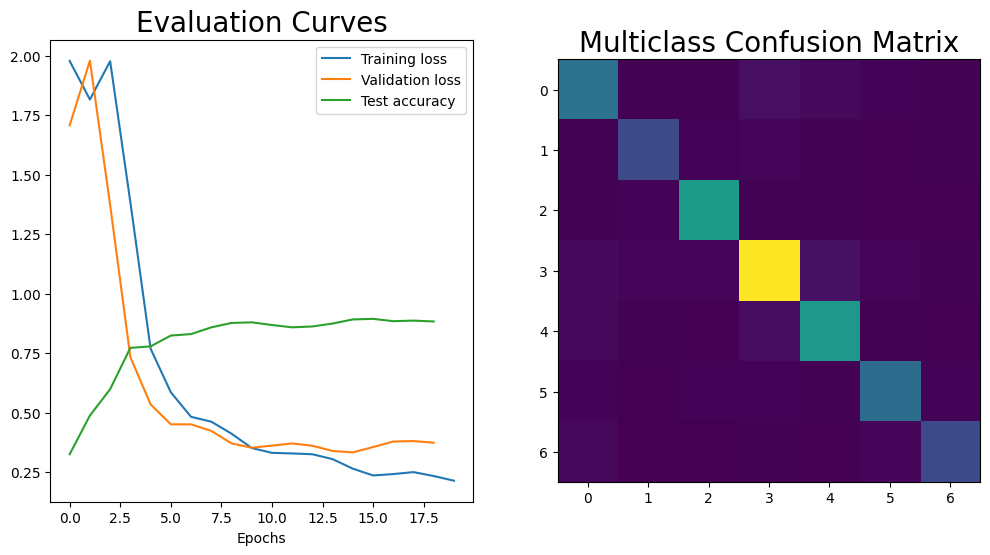


Training loss: 0.213755801320076
Test accuracy: 0.883004903793335


In [46]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

ax[0].plot(train_loss_arr, label='Training loss')
ax[0].plot(val_loss_arr, label='Validation loss')
ax[0].plot(test_acc_arr, label='Test accuracy')

ax[0].legend()
ax[0].set_title('Evaluation Curves', fontsize=20)
ax[0].set_xlabel('Epochs')

ax[1].imshow(test_cf)
ax[1].set_title('Multiclass Confusion Matrix', fontsize=20)

plt.show()

print(f'\nTraining loss: {train_loss_arr[-1]}')
print(f'Test accuracy: {test_acc_arr[-1]}')

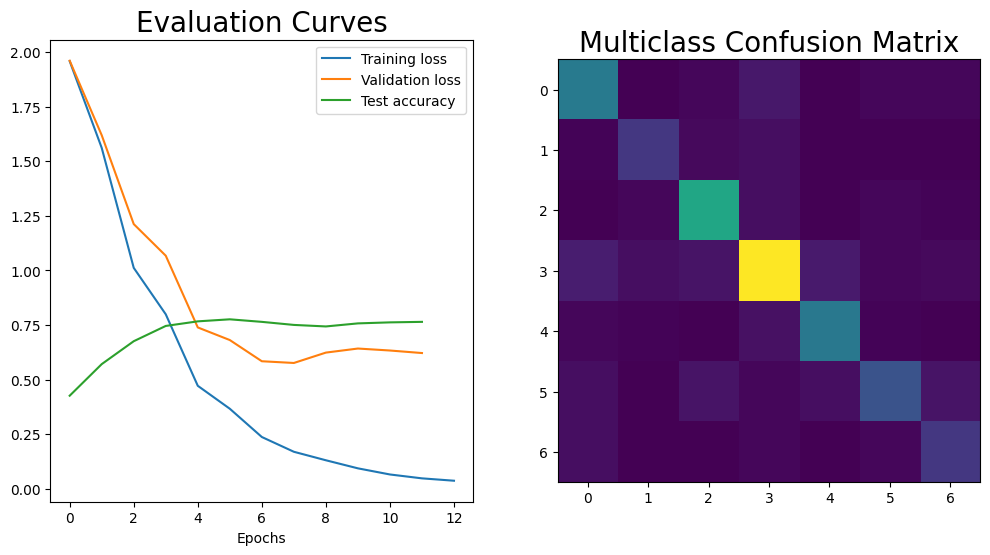


Training loss: 0.037471115589141846
Test accuracy: 0.7645687460899353


In [47]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

ax[0].plot(train_loss_arr1, label='Training loss')
ax[0].plot(val_loss_arr1, label='Validation loss')
ax[0].plot(test_acc_arr1, label='Test accuracy')

ax[0].legend()
ax[0].set_title('Evaluation Curves', fontsize=20)
ax[0].set_xlabel('Epochs')

ax[1].imshow(test_cf1)
ax[1].set_title('Multiclass Confusion Matrix', fontsize=20)

plt.show()

print(f'\nTraining loss: {train_loss_arr1[-1]}')
print(f'Test accuracy: {test_acc_arr1[-1]}')

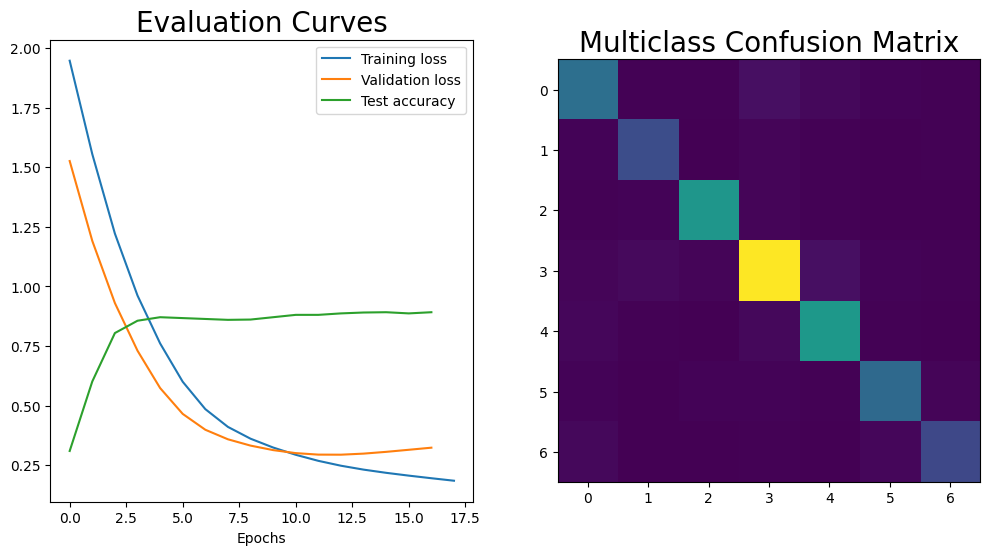


Training loss: 0.1842423677444458
Test accuracy: 0.8916256427764893


In [48]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

ax[0].plot(train_loss_arr2, label='Training loss')
ax[0].plot(val_loss_arr2, label='Validation loss')
ax[0].plot(test_acc_arr2, label='Test accuracy')

ax[0].legend()
ax[0].set_title('Evaluation Curves', fontsize=20)
ax[0].set_xlabel('Epochs')

ax[1].imshow(test_cf2)
ax[1].set_title('Multiclass Confusion Matrix', fontsize=20)

plt.show()

print(f'\nTraining loss: {train_loss_arr2[-1]}')
print(f'Test accuracy: {test_acc_arr2[-1]}')

## plotting node embeddings

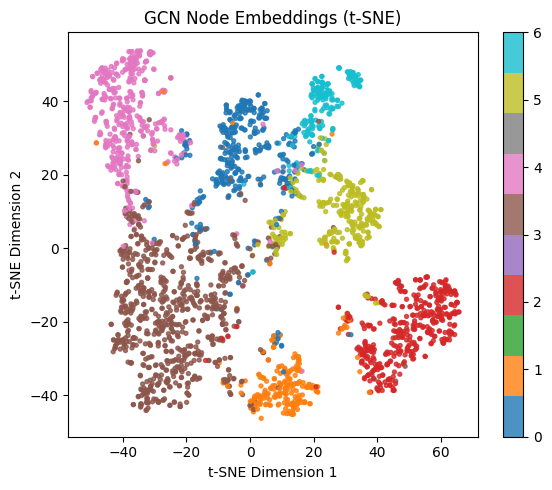

In [49]:
# Get node labels
labels = data.y.cpu().numpy()

# Plot
plt.figure(figsize=(6, 5))

scatter = plt.scatter(
    gcn_2d[:, 0],
    gcn_2d[:, 1],
    c=labels,
    cmap='tab10',
    s=8,
    alpha=0.8
)

plt.title("GCN Node Embeddings (t-SNE)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.colorbar(scatter)
plt.tight_layout()
plt.show()


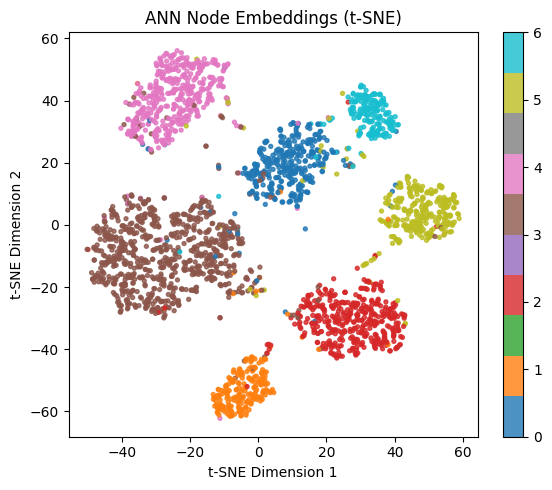

In [50]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(
    n_components=2,
    perplexity=30,
    n_iter=1000,
    random_state=42
)

ann_2d = tsne.fit_transform(ann_embeddings.cpu().numpy())

# Get node labels
labels = data.y.cpu().numpy()

# Plot
plt.figure(figsize=(6, 5))

scatter = plt.scatter(
    ann_2d[:, 0],
    ann_2d[:, 1],
    c=labels,
    cmap='tab10',
    s=8,
    alpha=0.8
)

plt.title("ANN Node Embeddings (t-SNE)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.colorbar(scatter)
plt.tight_layout()
plt.show()


##  Evaluate the Model for Different Split Ratios


----------------Split ratio: 0.8:0.1:0.1------------------
Epoch 0 | Train Loss 1.9750 | Val Loss 1.6947 | Test Acc 0.3926
Epoch 1 | Train Loss 1.7827 | Val Loss 2.0407 | Test Acc 0.4185
Epoch 2 | Train Loss 1.9801 | Val Loss 1.4178 | Test Acc 0.5296
Epoch 3 | Train Loss 1.3412 | Val Loss 0.7814 | Test Acc 0.7630
Epoch 4 | Train Loss 0.7489 | Val Loss 0.5856 | Test Acc 0.7519
Epoch 5 | Train Loss 0.6133 | Val Loss 0.4822 | Test Acc 0.7963
Epoch 6 | Train Loss 0.4648 | Val Loss 0.5543 | Test Acc 0.7815
Epoch 7 | Train Loss 0.4640 | Val Loss 0.5655 | Test Acc 0.7852
Epoch 8 | Train Loss 0.4370 | Val Loss 0.4772 | Test Acc 0.8333
Epoch 9 | Train Loss 0.3714 | Val Loss 0.4018 | Test Acc 0.8333
Epoch 10 | Train Loss 0.3378 | Val Loss 0.3639 | Test Acc 0.8704
Epoch 11 | Train Loss 0.3313 | Val Loss 0.3588 | Test Acc 0.8815
Epoch 12 | Train Loss 0.3330 | Val Loss 0.3552 | Test Acc 0.8852
Epoch 13 | Train Loss 0.3219 | Val Loss 0.3394 | Test Acc 0.8815
Epoch 14 | Train Loss 0.2888 | Val Loss 

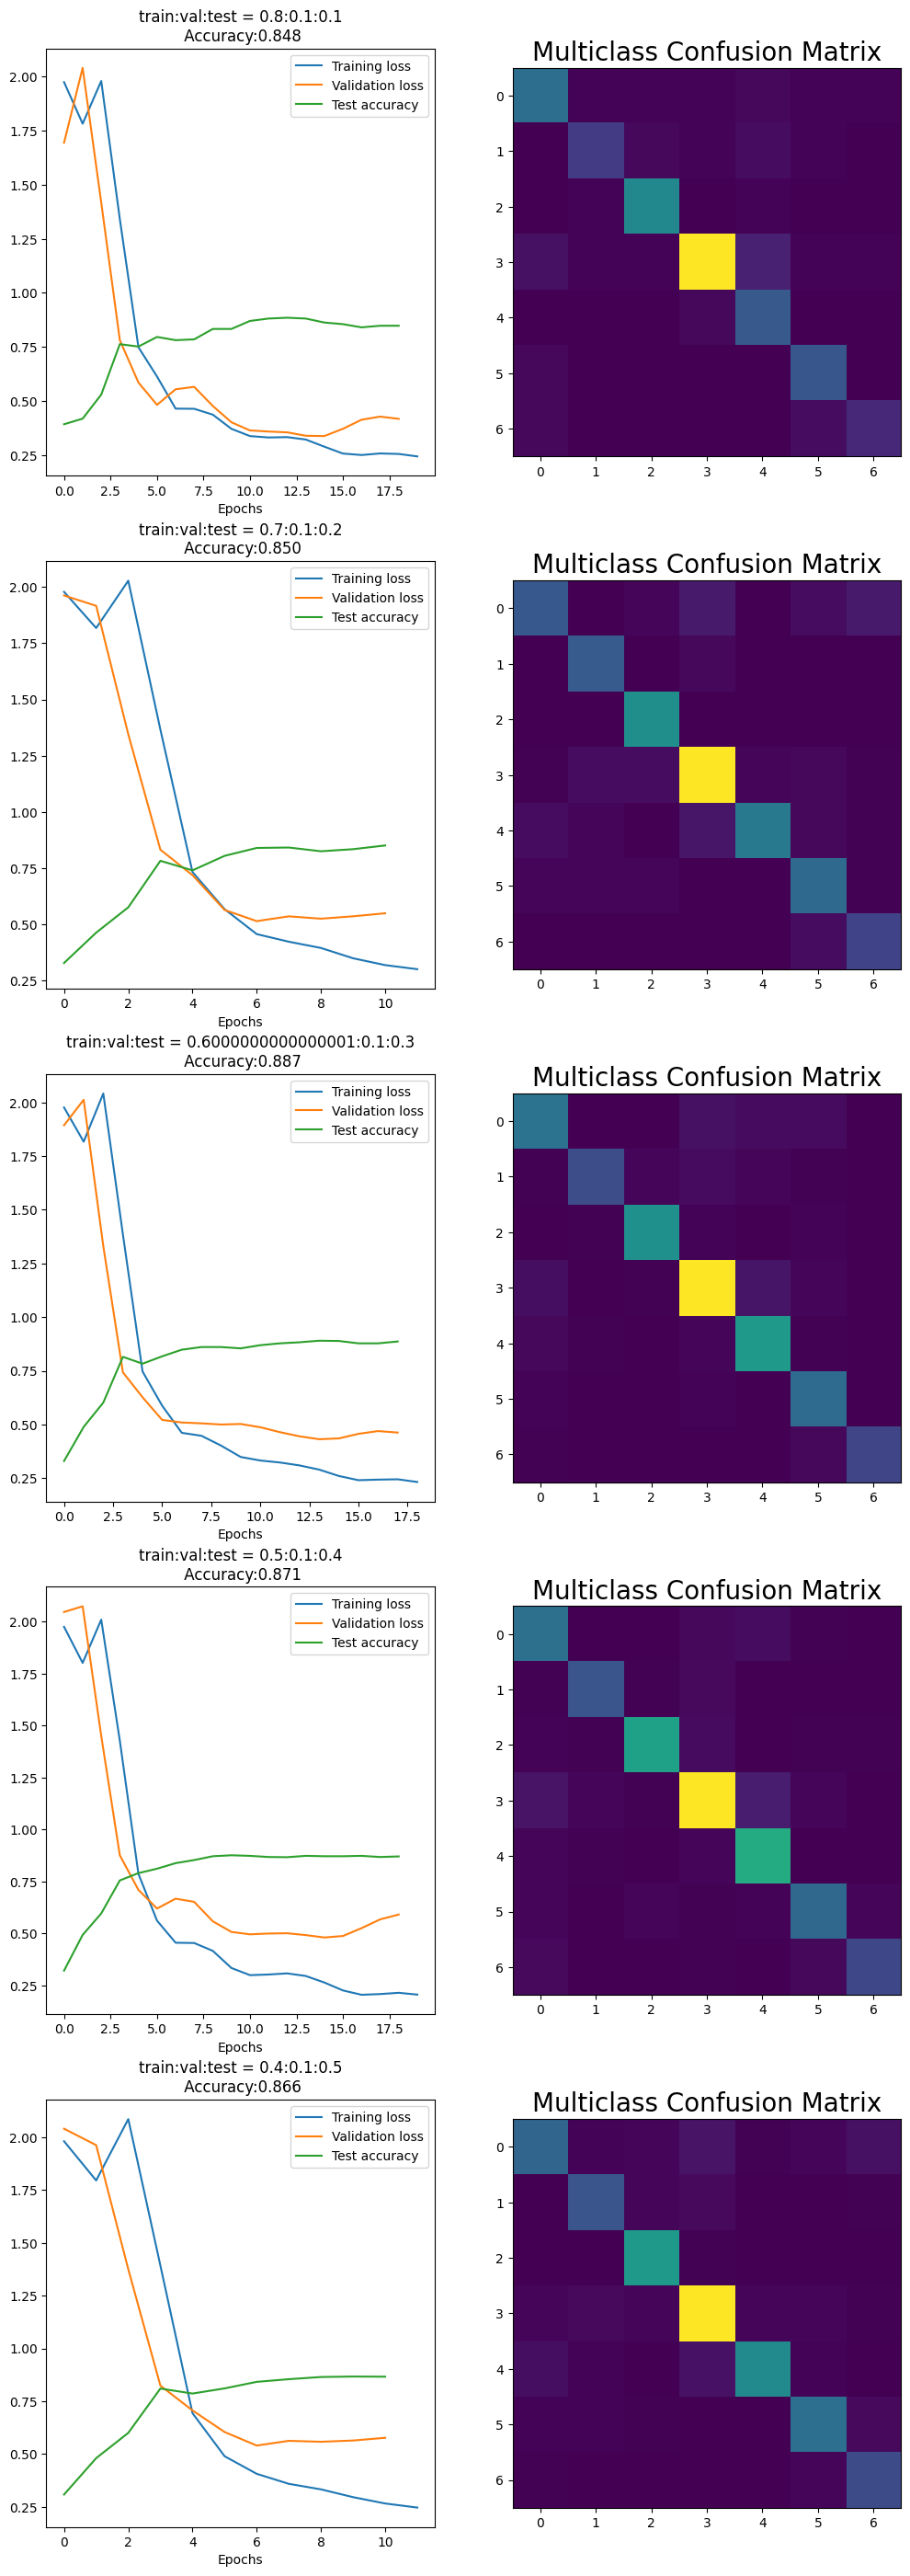

In [52]:
split_ratio_arr = [0.1, 0.2, 0.3, 0.4, 0.5]

fig, ax = plt.subplots(5, 2, figsize = (12, 35))

for i in range(len(split_ratio_arr)):
  print()
  print(f"----------------Split ratio: {0.9 - split_ratio_arr[i]}:0.1:{split_ratio_arr[i]}------------------")
  model1,train_loss_arr, val_loss_arr, test_acc_arr, test_cf = train_cora(split_ratio_arr[i], 100)

  ax[i, 0].plot(train_loss_arr, label='Training loss')
  ax[i, 0].plot(val_loss_arr, label='Validation loss')
  ax[i, 0].plot(test_acc_arr, label='Test accuracy')

  ax[i, 0].legend()
  ax[i, 0].set_title(f'train:val:test = {0.9 - split_ratio_arr[i]}:0.1:{split_ratio_arr[i]}\n Accuracy:{test_acc_arr[-1]:.3f}')
  ax[i, 0].set_xlabel('Epochs')

  ax[i, 1].imshow(test_cf)
  ax[i, 1].set_title("Multiclass Confusion Matrix", fontsize=20)